In [ ]:
!pip install diffusers["torch"] transformers torch accelerate

In [1]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DiffusionPipeline
import torch

In [ ]:
model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

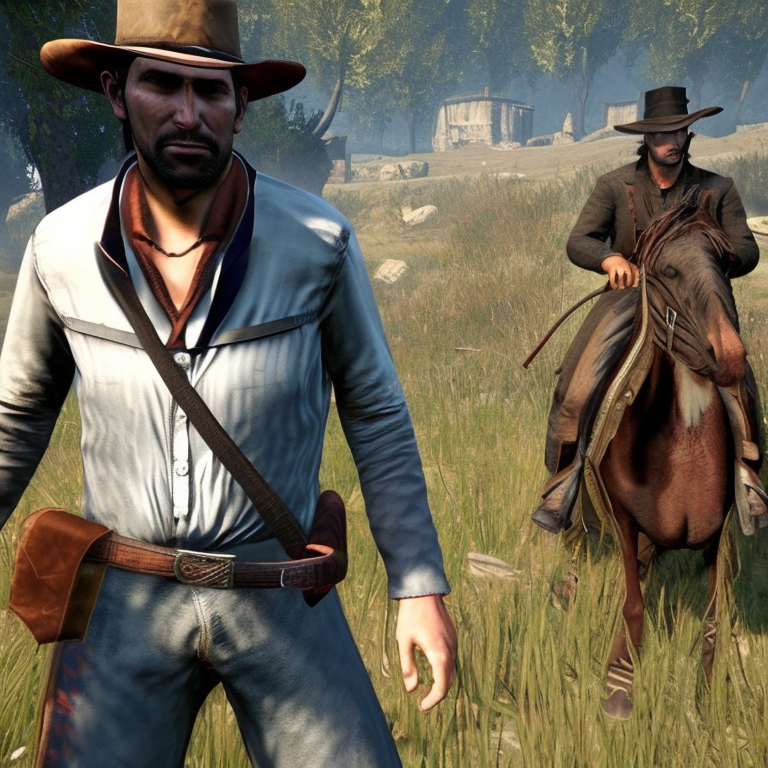

In [14]:
prompt = "@uribestiary donated 100bits to @menos_trece stream and he is playing red dead redemption"
image = pipe(prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

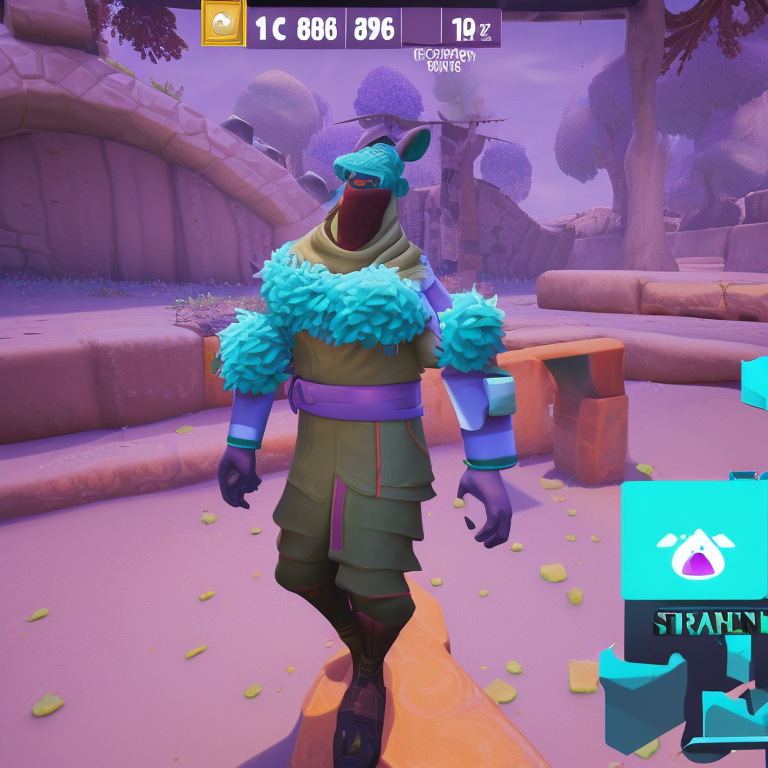

In [15]:
prompt = "@uribestiary donated 80 bits to @menos_trece stream and he is streaming fornite"
image = pipe(prompt).images[0]
image

Token indices sequence length is longer than the specified maximum sequence length for this model (109 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['uribestiary donated the 8 0 bits to @ menos _ trece asking him to save them and to fight if anyone tries to steal the bits from him']


  0%|          | 0/50 [00:00<?, ?it/s]

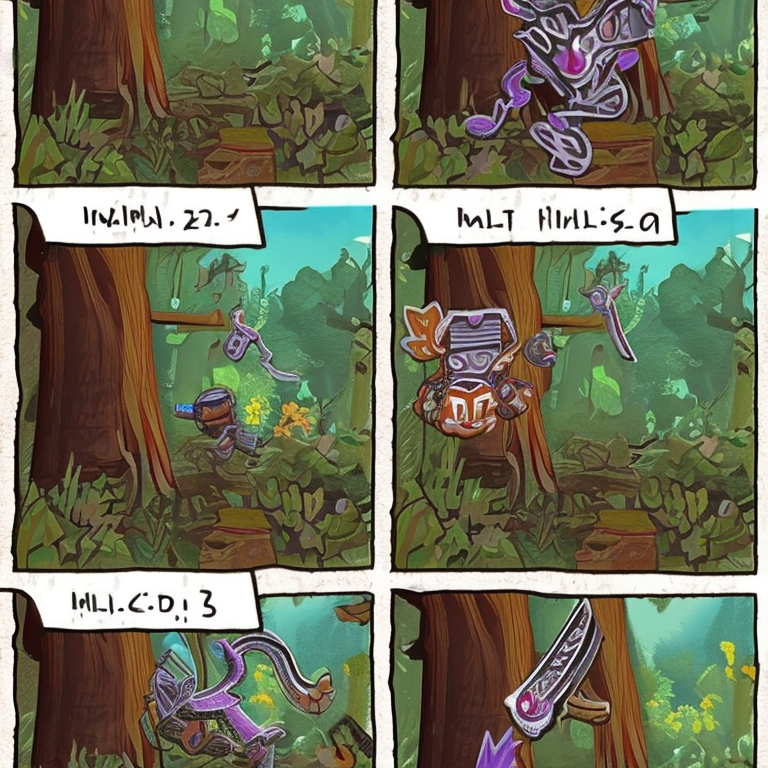

In [17]:
prompt = "@uribestiary is a fantastic animal in a forest. During the journey @uribestiary found 80 bits. @uribestiary kept the bits and fought robbers who tried to steal them. At the end of the @uribestiary journey, @uribestiary met @menos_trece. @menos_trece was playing fornite. @uribestiary donated the 80 bits to @menos_trece asking him to save them and to fight if anyone tries to steal the bits from him"
image = pipe(prompt).images[0]
image

In [15]:
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
base.to("cuda")
# base.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
# refiner.to("cuda")
refiner.enable_model_cpu_offload()

In [ ]:
# base.unet = torch.compile(base.unet, mode="reduce-overhead", fullgraph=True)
# refiner.unet = torch.compile(refiner.unet, mode="reduce-overhead", fullgraph=True)

In [ ]:
n_steps = 10
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]